# Applied Soccer Analytics with Python
##### *Devin Pleuler, March 2019*

### Using **Statsbomb** [Open Data][1] from *World Cup 2018*

#### Tutorial will cover:
1. Downloading and Parsing Statsbomb JSON
2. Basic Pass Map Visualization
3. Pass Classification using KMeans Clustering
4. Pass Sequence Prediction using LSTM
5. Evaluate Predictability of Team Ball Movement 

#### Python Dependances Include:
- *sklearn* for clustering
- *matplotlib* for visualization
- *keras* (and Tensorflow Backend) for neural network model
- *pandas* for data frame wrangling

[1]: https://github.com/statsbomb/open-data "Statsbomb Open Data Github Repository"

## 1. Downloading and Parsing Statsbomb JSON

In [2]:
import requests

In [5]:
# Statsbomb's competition 43 is the World Cup
match_info_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/matches/43.json"

# Pull data from url into python dictionary
games = requests.get(url=match_info_url).json()

# Use list comprehension to create a list of match ids
match_ids = [g['match_id'] for g in games]

In [6]:
# A list comprehension is the same as doing this:
match_ids = []
for g in games:
    m_id = g['match_id']
    match_ids.append(m_id)

In [3]:
# Build a Python Class for handling Pass Data
class Pass(object):
    def __init__(self, **kwargs):            
        for key, value in kwargs.items():
            setattr(self, key, value)
    
    # This method is useful later for creating training data for clustering
    def vector(self):
        return [self.x, self.end_x, self.y, self.end_y]

# Example Pass Object Instance
example_pass = Pass(**{"team":"Toronto FC", "x":42.0, "analyst":"Devin", "etc":"..."})

# ** allows you to pass keyworded variable length of arguments to a function

In [4]:
data_store = {}

# template URL at which each game's event data is stored
match_data_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{}.json"

# This takes some time, naturally
for match_id in match_ids:
    
    # Empty List for each game
    data_store[match_id] = []
    
    # Get all events from a particular game
    all_events = requests.get(url=match_data_url.format(match_id)).json()
    
    # Filter them by type-name Pass
    passes = [x for x in all_events if x['type']['name'] == "Pass"]
    for p in passes:
                
        # Store attributes in dictionary
        attributes = {
            "team": p["possession_team"]["name"],
            "possession_id": p["possession"],
            "x": p['location'][0],
            "y": p['location'][1],
            "end_x": p['pass']['end_location'][0],
            "end_y": p['pass']['end_location'][1]
        }
        
        # Construct Pass object from attribute keywords and store
        data_store[match_id].append(Pass(**attributes))

## 2. Basic Pass Map Visualization

In [5]:
import matplotlib.pyplot as plt

In [6]:
# Nice trick for high-resolution figures on retina screen
%config InlineBackend.figure_format = 'retina'

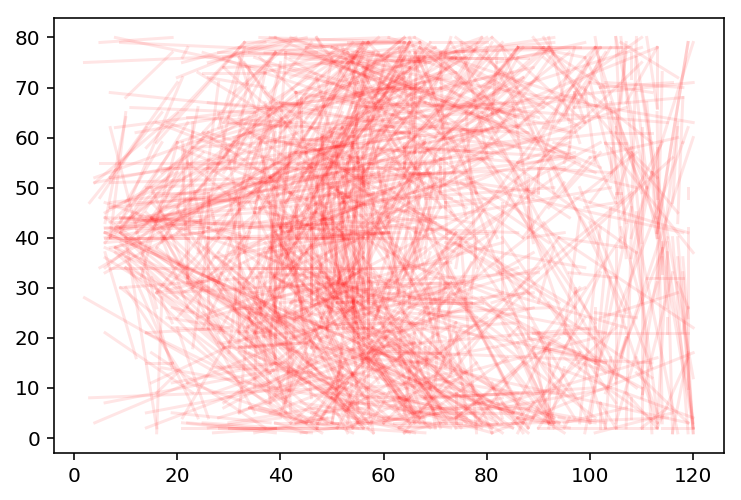

In [7]:
match_id = 7581 # Denmark vs. Croatia

# Plot all passes from single game
for p in [p for p in data_store[match_id]]:
    plt.plot([p.x, p.end_x],[p.y, p.end_y], c='red', alpha=0.1)
plt.show()

## 3. Pass Classification using KMeans Clustering

In [8]:
from sklearn.cluster import KMeans
import numpy as np

In [9]:
np.random.seed(42)

In [10]:
# Create training data for clustering
training_data = []
for match_id, passes in data_store.items():
    for p in passes:
        # For each pass, use the vector method
        training_data.append(p.vector())

In [11]:
# Perform the clustering on the training data
# 49 is mostly arbitrary, first index is used for end-of-sequence in later analysis
cluster_model = KMeans(n_clusters=49).fit(training_data)

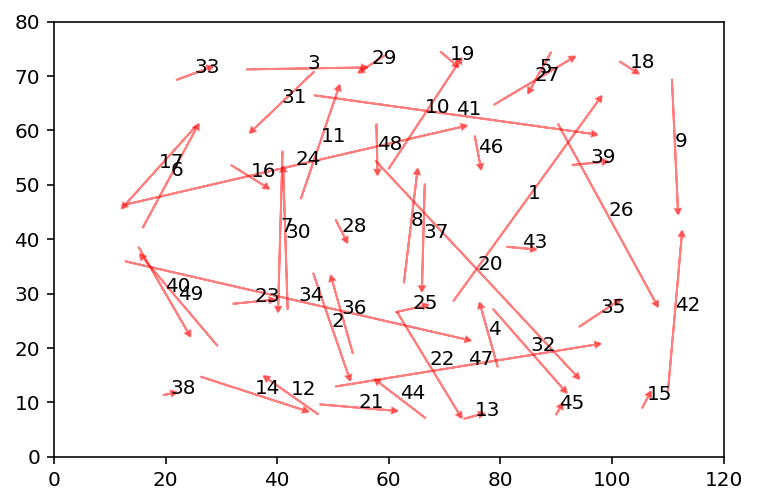

In [12]:
for i, (x, end_x, y, end_y) in enumerate(cluster_model.cluster_centers_):
    plt.arrow(x, y, end_x-x, end_y-y,
              head_width=1,
              head_length=1,
              color='red',
              alpha=0.5,
              length_includes_head=True)
    
    plt.text((x+end_x)/2, (y+end_y)/2, str(i+1))
    
plt.xlim(0,120)
plt.ylim(0,80)
plt.show()

In [13]:
for match_id, passes in data_store.items():
    for p in passes:
        # evaluate pass vector and make pass_cluster prediction
        # We add +1 to reserve index 0 for sequence modeling later
        pass_cluster = cluster_model.predict([p.vector()])[0] + 1
        
        # Set pass_cluster attribute on pass object
        setattr(p, "pass_cluster", pass_cluster)

## 4. Pass Sequence Prediction using LSTM

In [14]:
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import Sequential

Using TensorFlow backend.


In [15]:
# Construct Training Data
x_train = []
y_train = []

# For Use Later
team_labels = []

for match_id, passes in data_store.items():
    
    # Find Unique Possessions in pass data
    possessions = set([p.possession_id for p in passes])
    
    # For each possession, create a list of pass clusters inside it
    for possession_id in possessions:
        sequence = [[p.pass_cluster, p.team] for p in passes if p.possession_id == possession_id]
        sequence.append([0, None])
        
        # Create subsequences and trim/pad sequences to five (5) passes
        # TODO Make a graphic for this, since it's confusing
        for i in range(4 if len(sequence) > 5 else len(sequence) - 1):
            adj_seq = []
            target = sequence[i+1][0]
            for j in range(0,4):
                adj_seq.append(sequence[j][0] if j <= i else 0)
            adj_seq.append(0)
            
            x_train.append(np.array(adj_seq).reshape(5,1))
                        
            # One-hot encoding for target classification
            y_train.append([1 if k == target else 0 for k in range(0,50)])
            
            team_labels.append(sequence[i+1][1])
            

In [16]:
# Build Sequential Neural Network
model = Sequential()

# Add LSTM to Model
model.add(LSTM(200, input_shape=(5,1)))

# The Final Layer has a shape equal to the number of clusters
model.add(Dense(50, activation='softmax'))

# Compile using loss of Categorical Crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_1 (Dense)              (None, 50)                10050     
Total params: 171,650
Trainable params: 171,650
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Fit the model
# Takes ~8 minutes on my 4-year-old Macbook Pro
model.fit([x_train], [y_train], epochs=50, batch_size=50, verbose=1)

Epoch 1/50
32773/32773 [==============================] - 11s 327us/step - loss: 3.5948
Epoch 2/50
32773/32773 [==============================] - 10s 297us/step - loss: 3.5029
Epoch 3/50
32773/32773 [==============================] - 10s 298us/step - loss: 3.4148
Epoch 4/50
32773/32773 [==============================] - 10s 306us/step - loss: 3.3232
Epoch 5/50
32773/32773 [==============================] - 10s 318us/step - loss: 3.2234
Epoch 6/50
32773/32773 [==============================] - 10s 296us/step - loss: 3.1534
Epoch 7/50
32773/32773 [==============================] - 10s 298us/step - loss: 3.0943
Epoch 8/50
32773/32773 [==============================] - 10s 301us/step - loss: 3.0500
Epoch 9/50
32773/32773 [==============================] - 10s 296us/step - loss: 3.0082
Epoch 10/50
32773/32773 [==============================] - 13s 395us/step - loss: 2.9697
Epoch 11/50
32773/32773 [==============================] - 9s 283us/step - loss: 2.9491
Epoch 12/50
32773/32773 [======

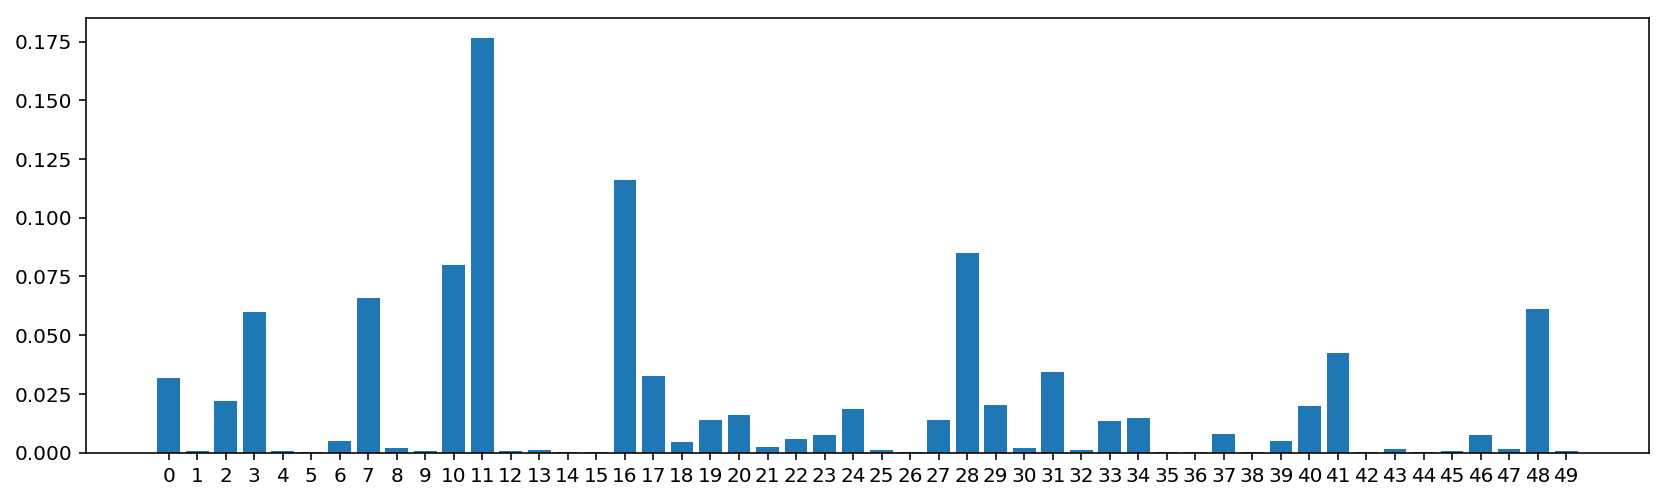

In [19]:
# Make Prediction on sequence
sequence = [30,0,0,0,0]
predictions = model.predict([[np.array(sequence).reshape(5,1)]])[0]

plt.figure(figsize=(14,4))
plt.bar(range(0,50), predictions, tick_label=[str(i) for i in range(50)])
plt.show()

# This makes intuitive sense when you look back at pass cluster map.

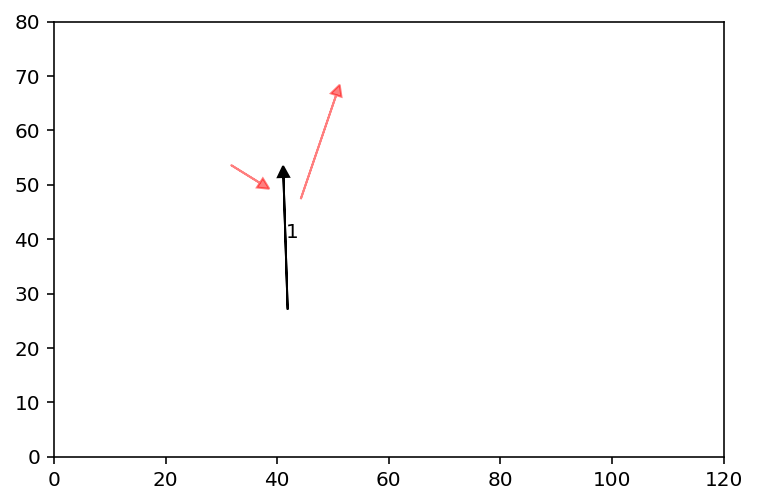

In [20]:
# Plot Possession Sequence, and Likely Next Passes

for i, (x, end_x, y, end_y) in enumerate([cluster_model.cluster_centers_[i-1] for i in sequence if i > 0]):    
    
    plt.arrow(x, y, end_x-x, end_y-y,
              head_width=2,
              head_length=2,
              color='black',
              length_includes_head=True)
    
    plt.text((x+end_x)/2, (y+end_y)/2, str(i+1))
    
for i, (x, end_x, y, end_y) in enumerate(cluster_model.cluster_centers_):
    
    if predictions[i+1] > 0.1:    
        plt.arrow(x, y, end_x-x, end_y-y,
                  head_width=2,
                  head_length=2,
                  color='red',
                  alpha=0.5,
                  length_includes_head=True)
plt.xlim(0,120)
plt.ylim(0,80)
plt.show()

## 5. Evaluate Team Ball Movement

In [21]:
import pandas as pd

In [22]:
team_list = {x:{"passes":0, "likely_passes":0} for x in set(team_labels)}

In [23]:
# This takes a minute or two
# (It's running prediections on entire data set)
for i, e in enumerate(x_train):
        
    pass_type = y_train[i].index(1)
    predictions = list(model.predict([[e]])[0])
    
    most_likely_pass = predictions.index(max(predictions))
    
    team_list[team_labels[i]]["passes"] += 1
    team_list[team_labels[i]]["likely_passes"] += 1 if pass_type == most_likely_pass else 0

In [24]:
table = [[k,
          team_list[k]["passes"],
          team_list[k]["likely_passes"]] for k,v in team_list.items() if k is not None]

df = pd.DataFrame(table, columns=["Team", "Pass Count", "Likely Passes"])

In [25]:
df['Predictability'] = df['Likely Passes'] / df['Pass Count']

In [26]:
df.sort_values(by=['Predictability'], ascending=True)

,Team,Pass Count,Likely Passes,Predictability
22,Iran,400,63,0.157500
5,Panama,462,77,0.166667
20,Iceland,478,87,0.182008
9,Mexico,816,154,0.188725
27,Sweden,787,149,0.189327
25,Uruguay,979,191,0.195097
31,Denmark,817,161,0.197062
13,Nigeria,546,108,0.197802
11,Senegal,520,103,0.198077
18,Serbia,556,113,0.203237
